# ROS ALE Figure 1

Generates Figure 1 from the manuscript "Lab evolution, transcriptomics, and modeling reveal mechanisms of paraquat tolerance" by Kevin Rychel et al., 2022.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Set-Up" data-toc-modified-id="Set-Up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Set Up</a></span></li><li><span><a href="#Write-Special-Functions" data-toc-modified-id="Write-Special-Functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Write Special Functions</a></span></li><li><span><a href="#Generate-Figure" data-toc-modified-id="Generate-Figure-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Generate Figure</a></span></li><li><span><a href="#DiMAs-(Differential-iModulon-Activities)" data-toc-modified-id="DiMAs-(Differential-iModulon-Activities)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>DiMAs (Differential iModulon Activities)</a></span></li></ul></div>

## Set Up

In [1]:
# use py file to set up workspace
from src.ros_ale_functions import *
import squarify # for treemaps

# load data
ica = load_json_model('input/precise1k_kr.json')
ros_meta = pd.read_csv('input/ros_ale_p1k_metadata.csv', index_col = 0)

# panel B
ale_gen1 = pd.read_csv('input/fig1/ale_generation1.csv')
ale_gen2 = pd.read_excel('input/fig1/ale_generation2.xlsx')

# panel C
gr_data = pd.read_csv('input/fig1/growth_rates.csv', index_col = 0)

# panel D
mutation_table = pd.read_excel('input/S1_ros_ale_mutations.xlsx', 
                               index_col = 0)
# panel E
aledb_data = pd.read_csv('input/fig1/aledb_snp_fractions.csv', index_col = 0)

# panel H
imodulon_table = pd.read_excel('input/S2_ros_ale_significant_iModulons.xlsx',
                               index_col = 0)

## Write Special Functions

Any functions called more than once are in src.ros_ale_functions. This figure uses additional ones, which are called only here.

In [2]:
def growth_rates(gr_data, ax):
    """
    Draws the growth rate vs. PQ plot in fig 1C
    
    Parameters
    ----------
    gr_data: table matching strains & PQ levels to measured GRs
    ax: axes to plot to
    
    Returns
    -------
    ax: axes with plot
    """
    
    palette = {'Start':'k', 'Evolved':'tab:blue'}
    
    # compute statistics for the lines
    plot_stats = pd.DataFrame(columns = ['evolved', 'pq', 'avg', 'dev'])
    for name, group in gr_data.groupby(['evolved_str', 'pq']):
        plot_stats = plot_stats.append({'evolved':name[0],
                                        'pq':name[1],
                                        'avg':group.growth_rate.mean(),
                                        'dev':group.growth_rate.std()},
                                        ignore_index = True)
    pqs = plot_stats.pq.unique()

    for s, group in plot_stats.groupby('evolved'):
        
        # plot the mean and error
        ax.plot(group.pq, group.avg, color = palette[s], label = s, zorder = 2)
        ax.fill_between(group.pq.astype(float), group.avg-group.dev, group.avg+group.dev,
                        color = palette[s], alpha = 0.1, zorder = 1)

        # set up jitter
        num_points = (gr_data.evolved_str == s).sum()
        scale = 30
        jitter = np.random.rand(num_points)*2*scale - scale
        
        # scatter the points
        ax.scatter(gr_data.loc[gr_data.evolved_str == s, 'pq'] + jitter,
                   gr_data.loc[gr_data.evolved_str == s, 'growth_rate'], 
                   color = palette[s], s = 1)

    ax.legend(fontsize = 7, loc = 'upper right')
    ax.set_ylabel('Growth Rate', fontsize = 7)
    ax.set_xlabel('Paraquat (μM)', fontsize = 7)
    ax.tick_params(labelsize = 7)
    ax.set_ylim(0, ax.get_ylim()[1])
    ax.set_xlim(-50, ax.get_xlim()[1])
    
    return ax

In [3]:
def convert_figsize(percentages, larger_figsize):
    """
    Helper function for treemap functions, used for fig 1D, H
    
    Parameters
    ----------
    percentages: width and height percentages of given rectangle
    larger_figsize: size of the rectangle this is nested in
    
    Returns
    -------
    res: new, smaller figsize
    """
    res = []
    for p, fs in zip(percentages, larger_figsize):
        res += [p/100*fs]
    return tuple(res)

def get_sizes(labels, ax, full_size):
    """
    Gets sizes for each part of a given treemap nesting

    Parameters
    ----------
    labels: labels for each component
    axes: axis with current treemap
    full_size: size of current treemap

    Returns
    -------
    sizes: dictionary frm labels to new sizes
    """
    sizes = {}
    for label, child in zip(labels, ax._children):
        percentages = (child._width, child._height)
        sizes[label] = convert_figsize(percentages, full_size)
    return sizes

In [4]:
def mut_treemap(ros_meta, mutation_table, ax, fig,
                out_dir = 'output/fig1_treemaps/'):
    """
    Draws nested treemaps (to be combined in illustrator)
        of mutations in the genome for fig 1D
        
    Parameters
    ----------
    ros_meta: main metadata table
    mutation_table: Table S1, contains the details for each mutation
        including categories we use here
    ax: axes to plot the largest treemap to
    fig: figure object, needed to get the exact size of axes
    out_dir: folder to save smaller treemaps to
    
    Returns
    -------
    ax: axes with largest treemap
    """
    # will need to know the size of the axes 
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    full_figsize = bbox.width, bbox.height

    # organize mutation data
    mut_df = pd.DataFrame(columns = ['category', 'gene', 'total'])
    for i, row in mutation_table.iterrows():
        mut_df.loc[i] = {'category':row['Treemap Category'],
                         'gene': row['Key Gene'],
                         'total':row[get_ev_strains(ros_meta)].sum()}
    mut_df = mut_df.sort_values('total', ascending = False)

    # get category counts for largest treemap
    # also assign colors
    category_df = pd.DataFrame(columns = ['total', 'color'])
    colors = {'Transporters':'tab:olive',
              'Central & Energy Metabolism':'tab:green',
              'Other':'lightgray',
              'Iron/Regulation':'tab:red',
              'Uncharacterized':'tab:gray',
              'Major Deletion':'tab:blue'}
    for category, group in mut_df.groupby('category'):
        category_df.loc[category] = {'total': group.total.sum(),
                                     'color': colors[category]}
    category_df = category_df.loc[colors.keys()]

    # largest nesting for each category
    squarify.plot(sizes = category_df.total,
                  label = category_df.index,
                  color = category_df.color,
                  ax = ax, text_kwargs = {'fontsize':6})
    ax.axis('off')

    # get the cat_sizes from this plot using helper functions
    cat_sizes = get_sizes(category_df.index, ax, full_figsize)

    # loop through each category
    for category, group in mut_df.groupby('category'):

        # group genes together
        this_cat_df = pd.Series(dtype = int)
        for gene, df in group.groupby('gene'):
            this_cat_df[gene] = df.total.sum()
        this_cat_df = this_cat_df.sort_values(ascending = False)

        # make a treemap for this category
        this_fig, this_ax = plt.subplots(dpi = fig.dpi,
            figsize = cat_sizes[category])
        squarify.plot(sizes = this_cat_df,
                      label = this_cat_df.index, 
                      color = category_df.color[category],
                      ax = this_ax, text_kwargs = {'fontsize':6})
        this_ax.axis('off')
        this_fig.savefig(out_dir + category.replace('/', '_') +'_mutations.pdf')

    return ax

In [5]:
def aledb_snps(aledb_data, ax):
    """
    Draws the bar plot of SNP types for fig 1E
    
    Parameters
    ----------
    aledb_data: table listing SNP fractions for each project
        from aledb.org
    ax: axes to plot to
    
    Returns
    -------
    ax: axes with plot
    """
    
    # define the SNP categories
    snps = ['A→T', 'T→A', 'A→G', 'G→A',
        'A→C', 'C→A', 'T→G', 'G→T',
        'T→C','C→T', 'G→C', 'C→G']
    cat_dict = {}
    for snp_str in snps:
        snp_str2 = snp_str.replace('C', 'G').replace('T', 'A')
        s = [snp_str2[0], snp_str2[2]]
        if (s[0] == s[1]):
            cat_dict[snp_str] = 'A↔T & G↔C'
        elif (s[0] > s[1]):
            cat_dict[snp_str] = 'GC→AT'
        else:
            cat_dict[snp_str] = 'AT→GC'
    cat_series = pd.Series(cat_dict, name = 'cat').to_frame()
    
    # organize SNPs by category
    to_plot = pd.DataFrame(columns = aledb_data.columns)
    
    for project, group in aledb_data.groupby('project'):
        for category, seq_changes in cat_series.groupby('cat'):
            df = group.loc[group.seq_change.isin(seq_changes.index)]
            to_plot = to_plot.append(pd.Series({
                'category': df.category.iloc[0],
                'project': project, 
                'seq_change':category,
                'fraction': df.fraction.sum()
            }), ignore_index = True)
            
    # prepare to plot
    palette = {'ROS TALE':'tab:blue',
           'Other':'darkgray'}
    order = ['GC→AT', 'AT→GC', 'A↔T & G↔C']
    
    # plot
    ax = sns.barplot(data = to_plot, x = 'fraction', y = 'seq_change', 
                     hue = 'category', ax = ax,  order = order,
                     palette = palette, errwidth = 1.5, edgecolor = 'k',
                     linewidth = 0.5)
    
    # clean up
    ax.legend(fontsize = 6.5)
    ax.tick_params(labelsize = 7)
    ax.set_ylabel('')
    ax.set_xlabel('Fraction', fontsize = 7)
    
    return ax

In [6]:
def DEG(ica, ros_meta, ax):
    """
    Draws the DEG plot for fig 1F
    Relies on the pymodulon function plot_dima()

    Parameters
    ----------
    ica: IcaData pymodulon object
    ros_meta: metadata for the ROS ALE samples
    ax: axes to plot to
    label: whether to label the genes

    Returns
    -------
    df_deg: dataframe of statistical results
    """
    # we want to use plot_dima(), which requires data be formatted
    #     as if it were an ICA data object
    gene_ica = IcaData(M = ica.M.T, A = ica.X, sample_table = ica.sample_table)
    
    # we need to scale the absolute difference threshold, since the default
    #     is for iModulon activities (A) instead of gene expression (X)
    A_range = ica.A.max().max() - ica.A.min().min()
    X_range = ica.X.max().max() - ica.X.min().min()
    default_thresh = 5
    scaled_thresh = default_thresh*X_range/A_range
    
    # get the samples to compare
    s1 = get_samples(ros_meta, ['0_0'], [250])
    s2 = get_samples(ros_meta, get_ev_strains(ros_meta),
                     [250, 750])
    
    # run the pymodulon dima function, to use the same statistical test
    #     but with our modified gene_ica object that treats expression as activity
    ax, df_deg = plot_dima(gene_ica, s1, s2, table = True, label = False, ax = ax,
                        threshold = scaled_thresh, scatter_kwargs = {'s':1})
    
    # clean up
    ax.set_ylabel('Evolved Strains [750 μM]\niModulon Activities', 
                 fontsize = 7)
    ax.set_xlabel('Parent Strain [250 μM]\niModulon Activities', 
                 fontsize = 7)
    ax.tick_params(labelsize = 7)
    
    return df_deg

In [7]:
def main_DiMA(ica, ros_meta, ax, label = False):
    """
    Draws the DiMA plot for fig 1G
    Relies on the pymodulon function plot_dima()

    Parameters
    ----------
    ica: IcaData pymodulon object
    ros_meta: metadata for the ROS ALE samples
    ax: axes to plot to
    label: whether to label the genes

    Returns
    -------
    df_dima: dataframe of statistical results
    """
    
    # get the samples to compare
    s1 = get_samples(ros_meta, ['0_0'], [250])
    s2 = get_samples(ros_meta, get_ev_strains(ros_meta),
                     [250, 750])
    
    # run the pymodulon dima function
    ax, df_dima = plot_dima(ica, s1, s2, table = True, ax = ax,
                            label = label, scatter_kwargs = {'s': 6},
                            label_font_kwargs = {'fontsize': 7})
    
    # clean up
    ax.set_ylabel('Evolved Strains [750 μM]\niModulon Activities', 
                 fontsize = 7)
    ax.set_xlabel('Parent Strain [250 μM]\niModulon Activities', 
                 fontsize = 7)
    ax.tick_params(labelsize = 7)
    
    df_dima = df_dima.sort_values('qvalue')
    
    return df_dima

In [8]:
def iM_treemap(ica, ros_meta, imodulon_table,
               ax, fig, out_dir = 'output/fig1_treemaps/'):
    """
    Draws nested treemaps (to be combined in illustrator)
        of iModulons in the transcriptome for fig 1H
        
    Parameters
    ----------
    ica, ros_meta: main data object and metadata
    imodulon_table: Table S2, contains the details for each iModulon
        including categories we use here
    ax: axes to plot the largest treemap to
    fig: figure object, needed to get the exact size of axes
    out_dir: folder to save smaller treemaps to
    
    Returns
    -------
    ax: axes with largest treemap
    """
    
    # will need to know the size of the axes 
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    full_figsize = bbox.width, bbox.height

    # Explained variance for significant iModulons are in the 
    # imodulon_table, but we need to compute it for the insignificant
    # iModulons -- do that below
    samples = get_samples(ros_meta, get_ev_strains(ros_meta),
                          [0, 250, 750])
    insig_iMs = pd.Series(dtype = float,
            index = set(ica.imodulon_names) - set(imodulon_table.index))
    for k in insig_iMs.index:
        insig_iMs[k] = explained_variance(ica, samples = samples,
                                          imodulons = k)
    insig_iMs = insig_iMs.sort_values(ascending = False)

    # get the explained variance for the significant iModulon categories
    # also assign colors
    category_df = pd.DataFrame(columns = ['exp_var', 'color'])
    colors = {'Genomic':'tab:blue',
              'Iron':'tab:red',
              'Metabolism':'tab:green',
              'Motility':'tab:cyan',
              'Stress':'tab:orange',
              'Uncharacterized':'tab:gray'}
    for category, group in imodulon_table.groupby('Treemap Category'):
        category_df.loc[category, 'exp_var'] = group['Explained Variance'].sum()
        category_df.color[category] = colors[category]
    category_df = category_df.sort_values('exp_var', ascending = False)


    # largest nesting will have overall explained variance
    sig_expvar = imodulon_table['Explained Variance'].sum()
    insig_expvar = insig_iMs.sum()
    no_expvar = 1 - sig_expvar - insig_expvar
    main_labels = ['Significant\niModulons', 
                   'Insignificant\niModulons', 
                   'Variation\nnot in iModulons']
    squarify.plot(sizes = [sig_expvar, insig_expvar, no_expvar], 
                  label = main_labels,
                  color = ['tab:green','tab:orange', 'tab:gray'], 
                  ax = ax, text_kwargs={'fontsize':7})
    ax.axis('off')

    # get the main_sizes from this plot using helper functions
    main_sizes = get_sizes(main_labels, ax, full_figsize)

    # insignificant iModulons
    insig_labels = list(insig_iMs.index[0:4]) + ['']*(len(insig_iMs)-4)
    insig_fig, insig_ax = plt.subplots(dpi = fig.dpi,
        figsize = main_sizes['Insignificant\niModulons'])
    squarify.plot(sizes = insig_iMs, label = insig_labels,
                  color = 'lightgray', ax = insig_ax,
                  text_kwargs = {'fontsize': 6})
    insig_ax.axis('off')
    insig_fig.savefig(out_dir + 'insignificant_iModulons.pdf')

    # significant iModulon categories
    sig_fig, sig_ax = plt.subplots(dpi = fig.dpi,
        figsize = main_sizes['Significant\niModulons'])
    squarify.plot(sizes = category_df.exp_var,
                  label = category_df.index,
                  color = category_df.color,
                  ax = sig_ax, text_kwargs = {'fontsize':6})
    sig_ax.axis('off')
    sig_fig.savefig(out_dir + 'significant_iModulons.pdf')

    # get the cat_sizes for nesting inside sig iMs
    cat_sizes = get_sizes(category_df.index, sig_ax, 
                           main_sizes['Significant\niModulons'])

    # loop through each category
    for category, group in imodulon_table.groupby('Treemap Category'):
        this_fig, this_ax = plt.subplots(dpi = fig.dpi,
            figsize = cat_sizes[category])
        squarify.plot(sizes = group['Explained Variance'],
                      label = group.index, 
                      color = category_df.color[category],
                      ax = this_ax, text_kwargs = {'fontsize':6})
        this_ax.axis('off')
        this_fig.savefig(out_dir + category+'_iModulons.pdf')
        
    return ax

In [9]:
def mutation_timeline(ale_gen1, ale_gen2, fig, colorbar_fig):
    """
    Draws the mutational timeline from ALE machine data
        for fig 1B
        
    Parameters
    ----------
    ale_gen1, ale_gen2: tables of PQ concentrations, growth
        rates, and elapsed time for each flask in the two 
        respective generations
    fig: figure object to plot to
    colorbar_fig: figure object to draw the colorbar on
        
    Returns
    -------
    subfigs: two column subfigures
    axs0: left axes, the generation 1 plots
    axs1: right axes, the generation 2 plots
    cb_ax: axes with the colorbar
    """

    # organize into dictionary of DFs, one for each strain
    def parse_ale_df(df):
        gen_dict = {}
        for c, values in df.iteritems():
            if 'skip' in c:
                continue
            s, col = c.split('__')
            if not(s in gen_dict.keys()):
                gen_dict[s] = values.dropna().to_frame()
                gen_dict[s].columns = [col]
            else:
                gen_dict[s][col] = values.dropna()
        return gen_dict

    # this is the organized data we will plot
    gen1_dict = parse_ale_df(ale_gen1)
    gen2_dict = parse_ale_df(ale_gen2)

    # generation two is by date, convert to 'time_since'
    for s, df in gen2_dict.items():
        df['time_since'] = [i.days for i in (df.date - df.date[0])]

    # stars in gen 1 (flasks with DNAseq)
    flasks_with_muts = {'1_0':[28, 32],
                        '2_0':[3, 11, 24, 36],
                        '3_0':[2, 7, 21, 27]}
    for s, flasks in flasks_with_muts.items():
        df = gen1_dict[s]
        df['DNA'] = False
        for f in flasks:
            df['DNA'].iloc[f-1] = True

        gen1_dict[s] = df

    # stars in gen 2 (flasks with DNAseq)
    flasks_with_muts2 = {'1_1':[20,44,83],
                         '1_2':[25,51,87],
                         '1_3':[23,61,104],
                         '1_4':[21,50,91],
                         '2_1':[21,59,97],
                         '2_2':[17,66,111],
                         '2_3':[18,71,119],
                         '3_1':[17,71,112],
                         '3_2':[34,44,76],
                         '3_3':[29,66,103],
                         '3_4':[31,59,77]}
    for s, flasks in flasks_with_muts2.items():
        df = gen2_dict[s]
        df['DNA'] = False
        fraction = df.shape[0]/flasks[-1]
        for f in flasks:
            idx = int(np.floor(fraction*f)-1)
            df['DNA'].iloc[idx] = True
        gen2_dict[s] = df

    # make the subfigures and axes
    subfigs = fig.subfigures(1, 2, wspace = 0)
    axs0 = subfigs[0].subplots(3, 1, sharey = True, sharex = True)
    axs1 = subfigs[1].subplots(11,1, sharex = True)

    # set up the color and marker settings
    markers = {False:'o', True:'*'}
    cmap = matplotlib.cm.get_cmap('cool')
    max_pq = max([df.PQ.max() for df in gen2_dict.values()])
    norm = matplotlib.colors.Normalize(0, max_pq)

    # draw the left side plots for gen 1
    for (s, df), ax in zip(sorted(gen1_dict.items()), axs0):

        # plot each PQ concentration with its own color
        for p, group in df.groupby('PQ'):
            ax.plot(group.CCD, group.GR, marker = markers[False], 
                    color = cmap(norm(p)), markersize = 3)

        # add the stars
        df_DNA = df.loc[df.DNA]
        ax.scatter(df_DNA.CCD, df_DNA.GR, marker = markers[True], 
                   color = 'k', zorder = 5, s = 25)

        ax.tick_params(labelsize = 7)

    # labels
    ax.set_xlabel('Cumulative Cell Divisions', fontsize = 7)
    subfigs[0].supylabel('Growth Rate (1/hr)', fontsize = 7)

    # draw the right side plots for gen 2
    for (s, df), ax in zip(sorted(gen2_dict.items()), axs1):

        # main pq colors
        for p, group in df.groupby('PQ'):
            ax.plot(group.date, [0]*group.shape[0],
                    color = cmap(norm(p)), marker = markers[False],
                    markersize = 3)

        # stars
        df_DNA = df.loc[df.DNA]
        ax.scatter(df_DNA.date, [0]*df_DNA.shape[0],
                   marker = markers[True], color = 'k', zorder = 5,
                   s = 25)

        ax.axis('off')

    # draw the colorbar
    cb_ax, skip_ax = colorbar_fig.subplots(2, 1)
    cb = matplotlib.colorbar.ColorbarBase(cb_ax, cmap = cmap, 
                            norm = norm, orientation = 'horizontal')
    cb.set_label('PQ (μM)', fontsize = 7)
    cb.ax.tick_params(labelsize = 7)
    skip_ax.axis('off')

    return subfigs, axs0, axs1, cb_ax

## Generate Figure

Final rearrangement is perfomed, and panel A is drawn in Adobe Illustrator. 

Note that due to a lack of suitable nesting treemap functions in Python, we place the larger fractions in the figure itself, then output pdfs for all smaller sections of the treemap, and organize it all in Illustrator.

/home/kevin/anaconda3/envs/py38env/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


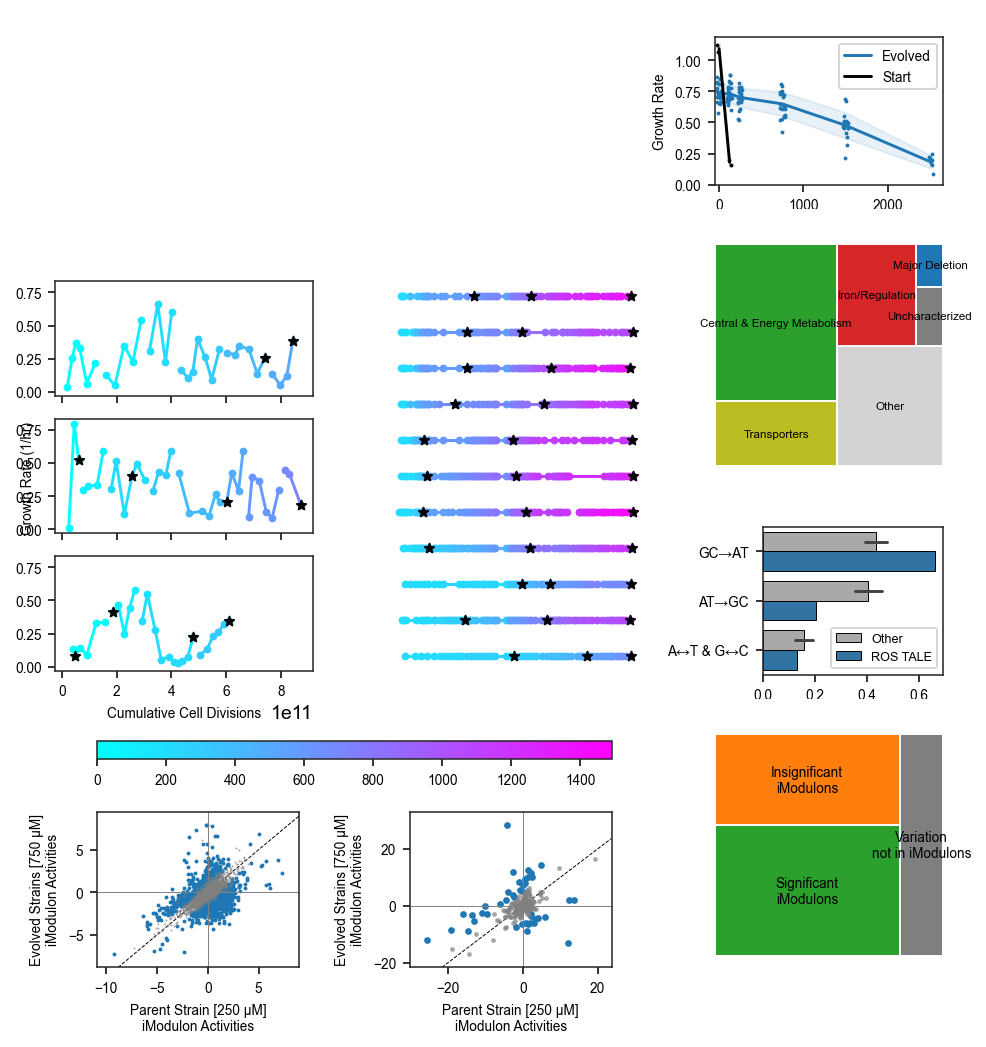

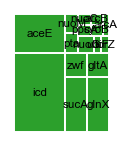

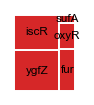

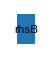

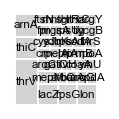

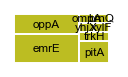

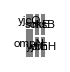

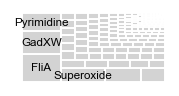

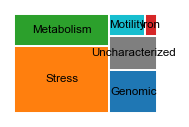

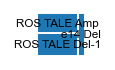

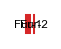

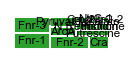

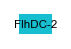

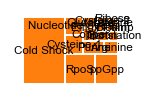

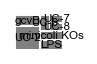

In [10]:
# layout
fig = plt.figure(figsize = (6.85, 7), dpi = 140)
subfigs = fig.subfigures(1, 2, width_ratios = [2.25, 1])
left_subfigs = subfigs[0].subfigures(4, 1, 
                height_ratios = [1,  2.5, 0.25, 1])
right_subfigs = subfigs[1].subfigures(4, 1, 
                height_ratios = [1, 1.5, 1, 1.5])

panel_f, skip1, panel_g = left_subfigs[3].subplots(1, 3,
                gridspec_kw = {'width_ratios': [1, 0.25, 1]})
panel_c = right_subfigs[0].subplots()
panel_d = right_subfigs[1].subplots()
skip2, panel_e = right_subfigs[2].subplots(1, 2, 
                gridspec_kw = {'width_ratios': [0.15, 1]})
panel_h = right_subfigs[3].subplots()
skip1.axis('off')
skip2.axis('off')

# B - PQ & GR
mutation_timeline(ale_gen1, ale_gen2,left_subfigs[1], left_subfigs[2])

# C - Growth Rates
growth_rates(gr_data, panel_c)

# D - Gene Treemap
mut_treemap(ros_meta, mutation_table, panel_d, fig)

# E - Mutation type bar chart
aledb_snps(aledb_data, panel_e)

# F - DEGs
df_deg = DEG(ica, ros_meta, panel_f)

# G - DiMAs
df_dima = main_DiMA(ica, ros_meta, panel_g)

# H - iModulon Treemap
iM_treemap(ica, ros_meta, imodulon_table, panel_h, fig)

fig.savefig('output/fig1_raw.pdf')

## DiMAs (Differential iModulon Activities)

More details used for labeling panel G are shown here, and the p values reported in most figure captions are computed.

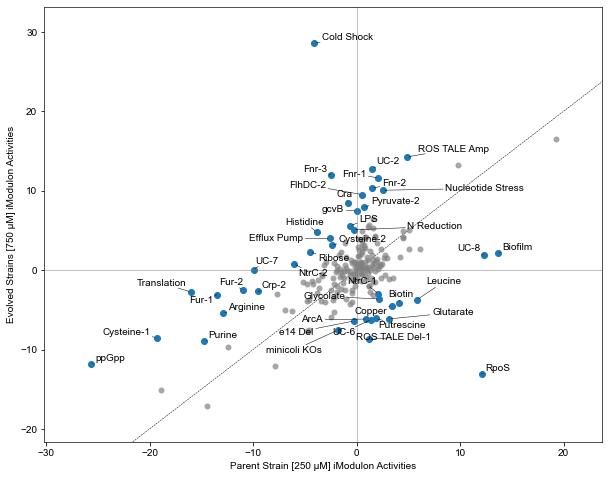

In [11]:
s1 = get_samples(ros_meta, ['0_0'], [250])
s2 = get_samples(ros_meta, get_ev_strains(ros_meta), [250, 750])

fig, dima_ax = plt.subplots(figsize = (10, 8))
dima_ax, df_dima = plot_dima(ica, s1, s2, table = True, ax = dima_ax)
dima_ax.set_ylabel('Evolved Strains [750 μM] iModulon Activities')
dima_ax.set_xlabel('Parent Strain [250 μM] iModulon Activities')

df_dima = df_dima.sort_values('qvalue')

In [12]:
# The qvalues shown here are the p-values reported throughout
# the manuscript
# this is also part of Table S2
df_dima

,difference,pvalue,qvalue,0,1
ROS TALE Del-1,-9.918641,0.000004,0.000869,1.182312,-8.736329
Cold Shock,32.640883,0.000016,0.001558,-4.071137,28.569746
Glutarate,-9.254651,0.000076,0.005083,3.105739,-6.148912
ROS TALE Amp,9.373360,0.000208,0.010457,4.879853,14.253212
Ribose,6.715756,0.000280,0.011238,-4.472718,2.243038
Pyruvate-2,7.277014,0.000351,0.011762,0.697360,7.974373
Leucine,-9.577748,0.000631,0.015668,5.845997,-3.731750
e14 Del,-6.148355,0.000700,0.015668,-0.258856,-6.407211
Glycolate,-5.782124,0.000779,0.015668,2.153461,-3.628663
Biofilm,-11.522793,0.000875,0.015986,13.657661,2.134869
